# 1. Entendimiento de datos
This notebooks has the code needed to analyze the GDB data from univariate analysis to bivariate analysis against the target column.

In [1]:
%%capture
!pip install pylev
!pip install pyarrow

## Imports

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import json

from scripts import univariate_utils, multivariate_utils

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import combinations

import pylev
import numpy as np

## Constants

In [3]:
SCRIPTS_PATH = "scripts"

In [4]:
PIB_FILE_PATH = "data/gapminder_final.csv"

In [5]:
REGIONS_FILE = "data/countries.json"

In [6]:
TARGET_VARIABLE = "incomeperperson"
ID_COLUMN = "country"

In [7]:
REGION_COLUMNS = [
    "independent", "region", "subregion", "landlocked", "area"
]

In [8]:
SAVING_FILE_PATH = "data/gapminder_with_extras.parquet"

In [9]:
# https://en.wikipedia.org/wiki/Developed_country
DEVELOPED_COUNTRIES = [
"Switzerland",
"Norway",
"Iceland",
"Hong Kong",
"Australia",
"Denmark",
"Sweden",
"Ireland",
"Germany",
"Netherlands",
"Finland",
"Singapore",
"Belgium",
"New Zealand",
"Canada",
"Liechtenstein",
"Luxembourg",
"United Kingdom",
"Japan",
"South Korea",
"United States",
"Israel",
"Malta",
"Slovenia",
"Austria",
"United Arab Emirates",
"Spain",
"France",
"Cyprus",
"Italy",
"Estonia",
"Czechia",
"Greece",
"Poland",
"Bahrain",
"Lithuania",
"Saudi Arabia",
"Portugal",
"Latvia",
"Andorra",
"Croatia",
"Chile",
"Qatar",
"San Marino",
"Slovakia",
"Hungary",
"Argentina",
"Turkey",
"Montenegro",
"Kuwait",
"Brunei",
"Russia",
"Romania",
"Oman",
"Bahamas",
"Kazakhstan",
"Trinidad and Tobago",
"Costa Rica",
"Uruguay",
"Belarus",
"Panama",
"Malaysia",
"Georgia",
"Mauritius",
"Serbia",
"Thailand"
]

## Utils

In [10]:
def load_countries_region():
    """Loads country region info"""
    with open(REGIONS_FILE, "r") as f: 
        regions = json.load(f)
        df_regions = pd.DataFrame(regions)[
            ["name"] + REGION_COLUMNS
        ]
        df_regions["name"] = df_regions["name"].apply(
            lambda name: name["common"]
        )
        return df_regions

In [11]:
# https://github.com/mledoze/countries
def add_region_to_pib(df_pib, df_regions):
    """Adds region info to countries GDP dataframe"""
    df_data = df_pib.merge(
        df_regions,
        left_on="country",
        right_on="name",
        how="left"
    )

    df_data.drop(columns="name", inplace=True)
    no_region_countries = df_data[
        df_data["region"].isnull()
    ]["country"].tolist()
    named_countries = df_regions["name"].tolist()
    for no_region_country in no_region_countries:
        is_no_region_country = df_data["country"] == no_region_country
        closest_country_index = np.argmin([
            pylev.levenshtein(
                no_region_country,
                named_country
            )
            for named_country in named_countries
        ])
        closest_country_info = df_regions.iloc[closest_country_index][REGION_COLUMNS].values
        df_data.loc[is_no_region_country, REGION_COLUMNS] = closest_country_info
    df_data["is_developed"] = df_data["country"].apply(
        lambda country: country in DEVELOPED_COUNTRIES
    ).astype(str)
    return df_data

## Execution

### Data loading and overview

It seems that all the columns are numerical, except by "country", and at a first sight, the following columns have nulls:
- hivrate
- oilperperson
- polityscore
- relectricperperson

Also, variables have different magnitude orders, then to train a model scaling may be needed.

In [12]:
df_pib = pd.read_csv(PIB_FILE_PATH)

In [13]:
df_pib.head(5)

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,NaN,-1.0,NaN,13.548420,71.300003,38.58
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,NaN,NaN,NaN,3.108603,66.900002,39.84
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,0.3,53.740217,81.855,1.207250,10.0,1176.385457,4.930045,46.400002,68.08


In [14]:
NUMERICAL_COLUMNS = [col for col in df_pib.columns if col not in [TARGET_VARIABLE, ID_COLUMN]]

In [15]:
df_regions = load_countries_region()

### Non-graphic univariate analysis

#### Null valoration

The dataset has 178 country entries, where the following columns have no null values:
- country
- alcconsumption
- lifeexpectancy
- suicideper100th
- urbanrate

The following variables have a low rate of nulls, being it under 7%:
- incomeperperson
- armedforcesrate
- breastcancerper100th
- co2emissions
- femaleemployrate
- internetuserate
- polityscore
- employrate

And the columns that could be discarded because of a high number of nulls are (specially oilperperson):
- hivrate
- oilperperson
- relectricperperson

In [16]:
univariate_utils.make_not_graphic_analysis(df_pib)

----- dataset info -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15

country                 0.000000
incomeperperson         0.016854
alcconsumption          0.000000
armedforcesrate         0.022472
breastcancerper100th    0.005618
co2emissions            0.011236
femaleemployrate        0.005618
hivrate                 0.129213
internetuserate         0.022472
lifeexpectancy          0.000000
oilperperson            0.623596
polityscore             0.061798
relectricperperson      0.207865
suicideper100th         0.000000
employrate              0.005618
urbanrate               0.000000
dtype: float64

----- Object column statistics -----


,country
count,178
unique,166
top,Ireland
freq,2


----- Number column statistics -----


,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
count,175.000000,178.000000,174.000000,177.000000,1.760000e+02,177.000000,155.000000,174.000000,178.000000,67.000000,167.000000,141.000000,178.000000,177.000000,178.000000
mean,7553.392250,6.753539,1.376696,37.615254,5.757754e+09,47.607909,1.854516,34.740125,69.414949,1.432081,3.502994,1181.715476,9.984100,58.854237,56.282135
std,11074.571742,5.139950,1.499729,23.225333,2.734690e+10,14.741347,4.276108,28.088371,9.808335,1.771041,6.423671,1655.388823,6.521086,10.334804,22.561796
min,103.775857,0.030000,0.000000,3.900000,8.506667e+05,12.400000,0.060000,0.210066,47.794000,0.032281,-10.000000,0.000000,0.201449,34.900002,10.400000
5%,241.729899,0.337000,0.143784,12.860000,8.022667e+06,22.140001,0.060000,1.700015,50.136100,0.152982,-7.000000,31.544564,1.778754,41.920000,18.283000
25%,609.744287,2.445000,0.491714,20.400000,8.755725e+07,38.799999,0.100000,9.924668,62.725000,0.580038,-2.500000,239.389457,5.785134,51.400002,36.965000
50%,2425.471293,5.920000,0.931293,30.000000,3.054792e+08,48.400002,0.400000,29.939930,72.974000,0.890813,6.000000,614.907287,9.050307,58.799999,59.600000
75%,8880.432039,9.990000,1.601996,50.300000,2.391801e+09,56.000000,1.200000,55.973228,76.127500,1.586422,9.000000,1566.106139,12.409866,65.000000,73.460000
95%,32954.632381,16.300000,4.542295,86.800000,2.314134e+10,73.880002,11.150000,83.607776,81.409250,4.272204,10.000000,4304.514402,22.854566,78.199997,91.711000
max,52301.587180,23.010000,9.820127,101.100000,3.340000e+11,83.300003,25.900000,95.638113,83.394000,12.228645,10.000000,11154.755030,35.752872,83.199997,100.000000


----- First five rows -----


,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Ireland,27595.091350,14.92,0.450024,74.9,1.633779e+09,51.000000,0.2,69.770394,80.557,1.700262,10.0,2051.802338,10.365070,59.900002,61.34
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72
2,Central African Rep.,239.518749,3.17,0.148659,16.5,8.338000e+06,62.900002,4.7,2.300027,48.398,NaN,-1.0,NaN,13.548420,71.300003,38.58
3,Barbados,9243.587053,6.42,0.663956,62.5,3.616067e+07,60.299999,1.4,70.028599,76.835,NaN,NaN,NaN,3.108603,66.900002,39.84
4,Italy,18982.269290,9.72,1.729346,74.4,1.900045e+10,35.799999,0.3,53.740217,81.855,1.207250,10.0,1176.385457,4.930045,46.400002,68.08


#### Centrality and Dispersion

By using histograms, boxplots and the statistics above, several assumptions can be made over each numerical column:

##### Country
- There are repeated countries such as Ireland with two values.

##### alcconsumption
- The median consumption is around 6 litres a year, but there is a country with a consumption a lot higher, maybe an outlier, of 23 per year.


##### armedforcesrate
- Being a percentage of the population working in the armed forces, it is weird that there are some countries with values of zero. Also the normal values tend to be below 4.5%.

##### breastcancerper100th
- Its median is 30 women per 100.000 women with cancer, but there are countries with as low as 3.9 and some with 101 as high.

##### c02emissions
- There is a really high accumulation of values to the smaller side of the distribution, with a percentile 75 of 2.391.801.000 tones. However there are some countries that exceed this value by an order of magnitude, having an extreme c02 emission level. These high emissions could affect the regression model.

##### femaleemployrate
- It is highly variable between 12% and 83%, having as a median 48% of the women 15+ employed.

##### hivrate
- It is generally a value very close to zero, but in some countries there is an extreme situation of having up to 25% of the population selected with this disease. These may be outliers.

###### internetuserate
- Highly variable with countries having less than 1% of the people with internet access, and some other countries with almost the opposite situation, having 95% of the population with internet access.

###### lifeexpectancy
- For all countries life expectancy is above 47 years.

##### oilperperson
- Some countries have an excesive consumption of 12 tonnes per year per person, while the median is about 0.89 tonnes per person.

##### polityscore
- Seems to be in the correct range, but balanced around positive values with a median of 6.0.

##### relectricperperson
- It has values of zero, meaning that some people has no electricity in some countries, which may be an anomaly or error. The same happens in the opposite spectrum with values over 11000 KwH, but most values are accumulated towards zero.

##### suicideper100th
- There are countries with less than 1 person that died by suicide for 100.000 habitants, but in general, values accumulate around 10.

##### employrate
- All values are over 34%. There is no country with 100%.

##### percentrate
- All values are over 10%.


In [17]:
2.391801e+09

2391801000.0

alcconsumption


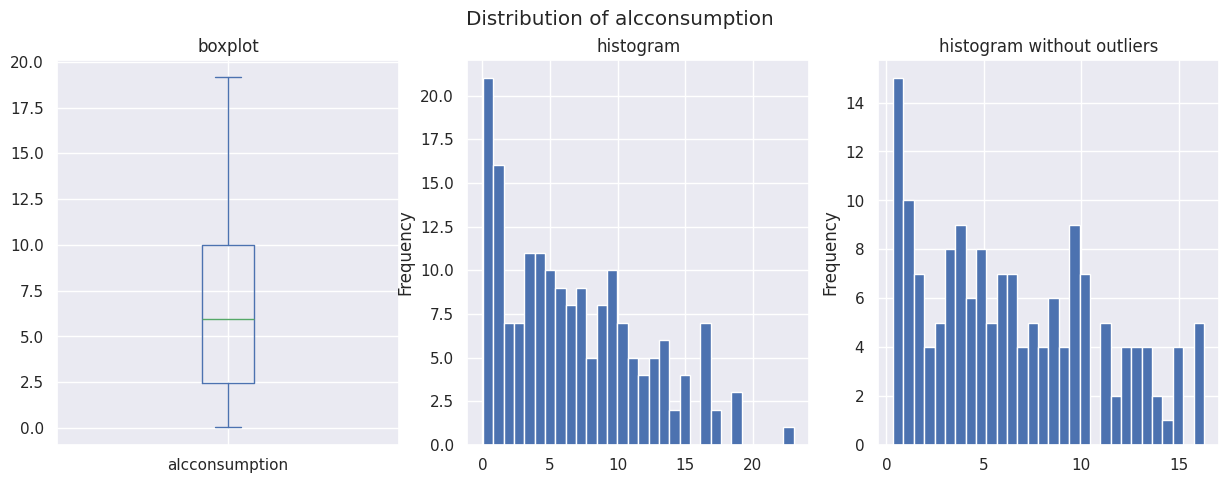

armedforcesrate


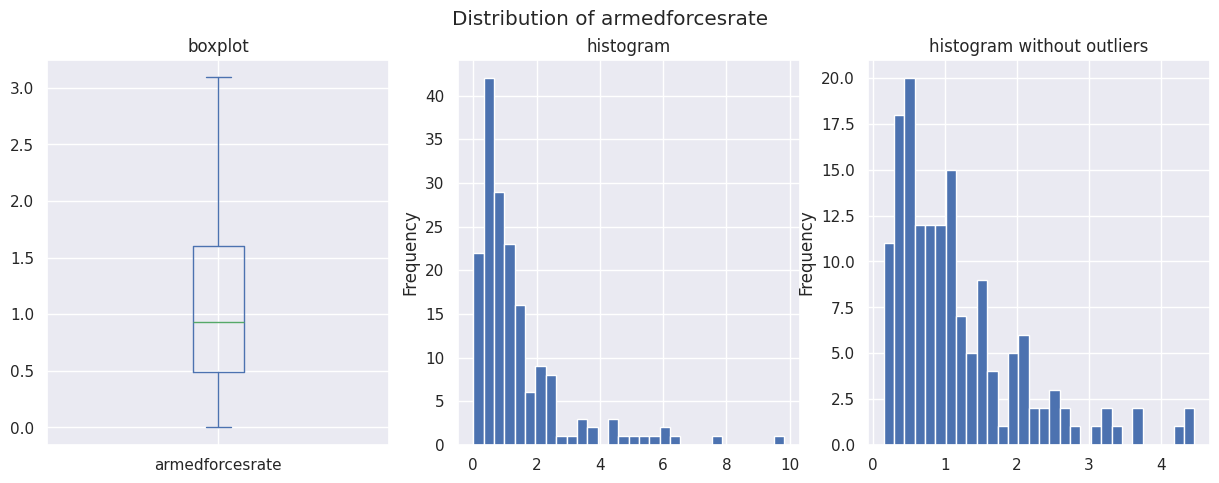

breastcancerper100th


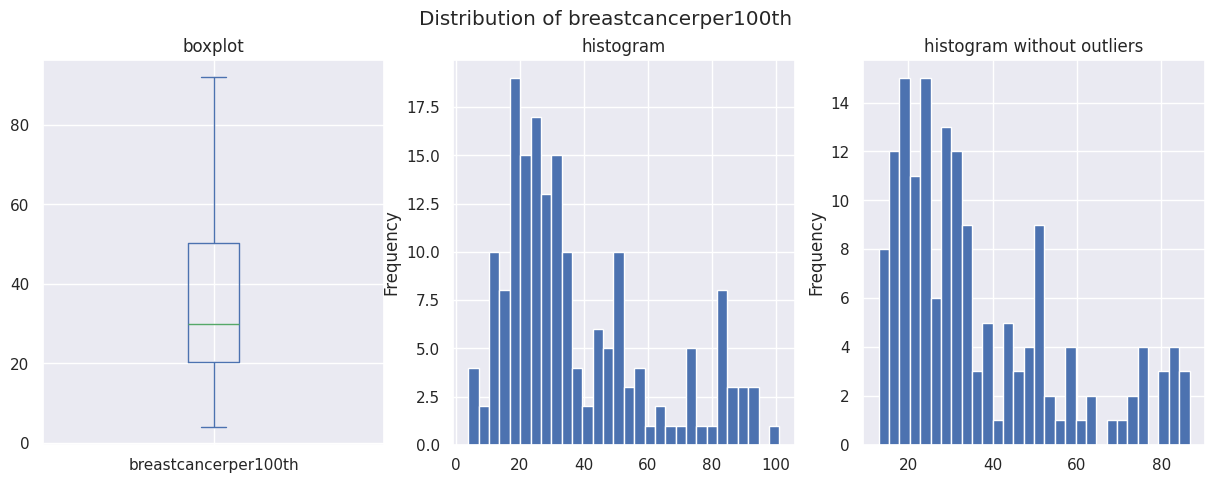

co2emissions


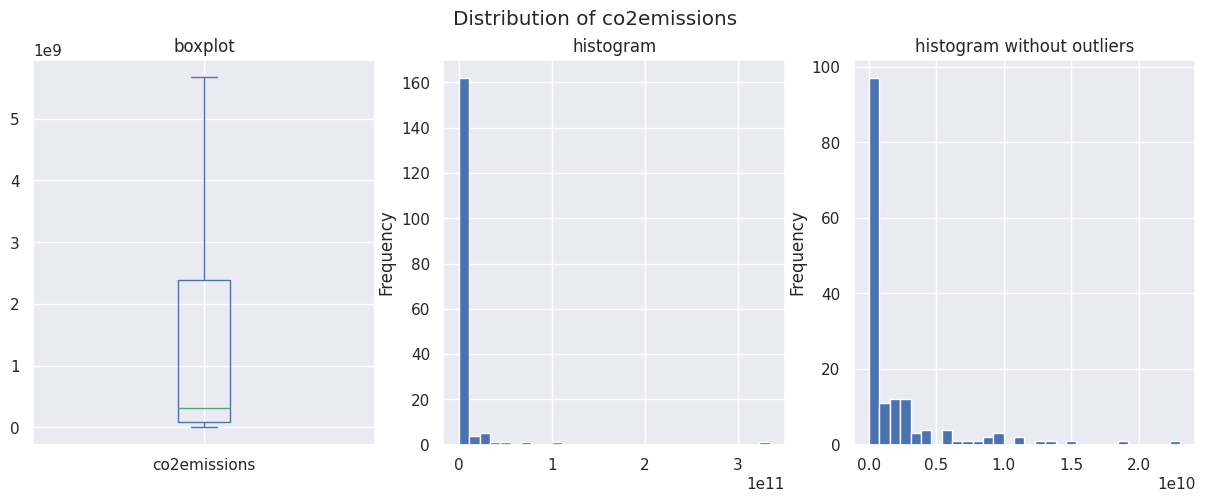

femaleemployrate


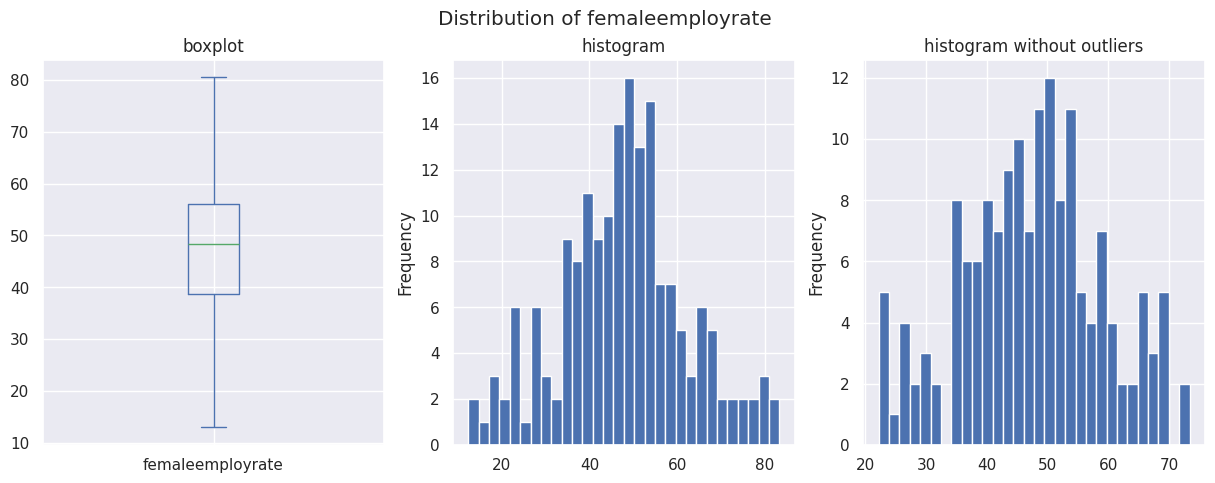

hivrate


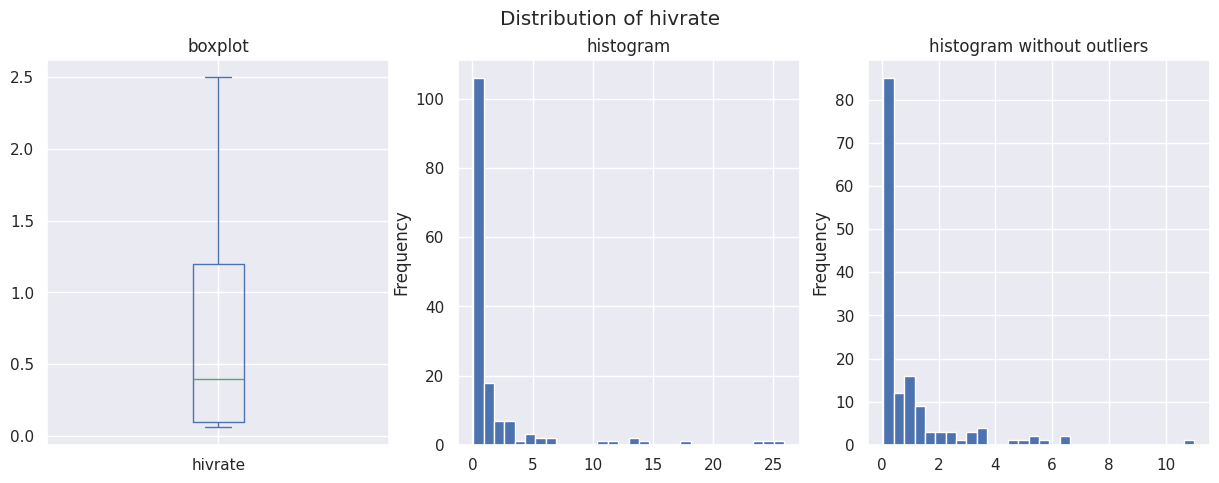

internetuserate


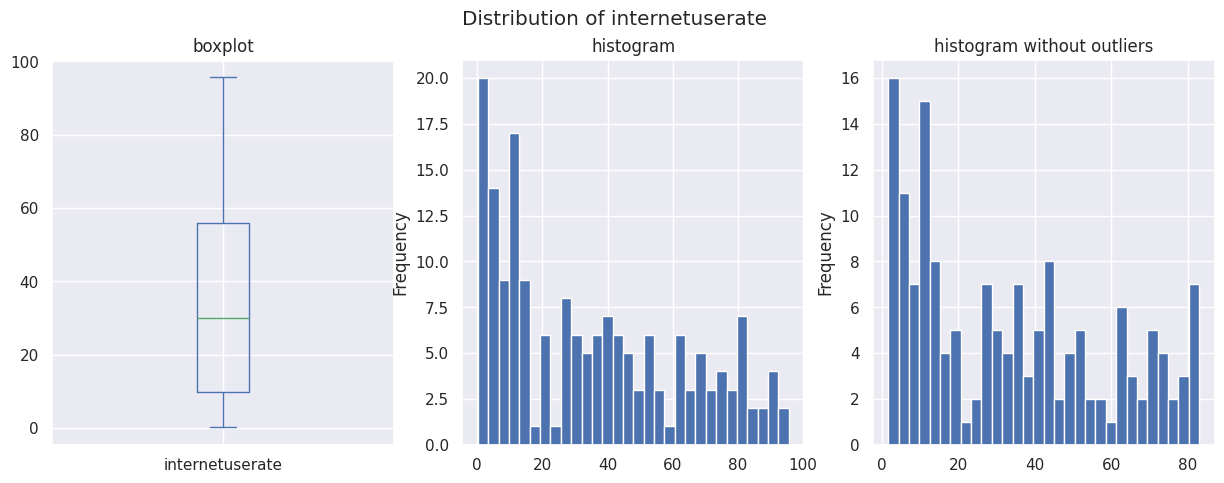

lifeexpectancy


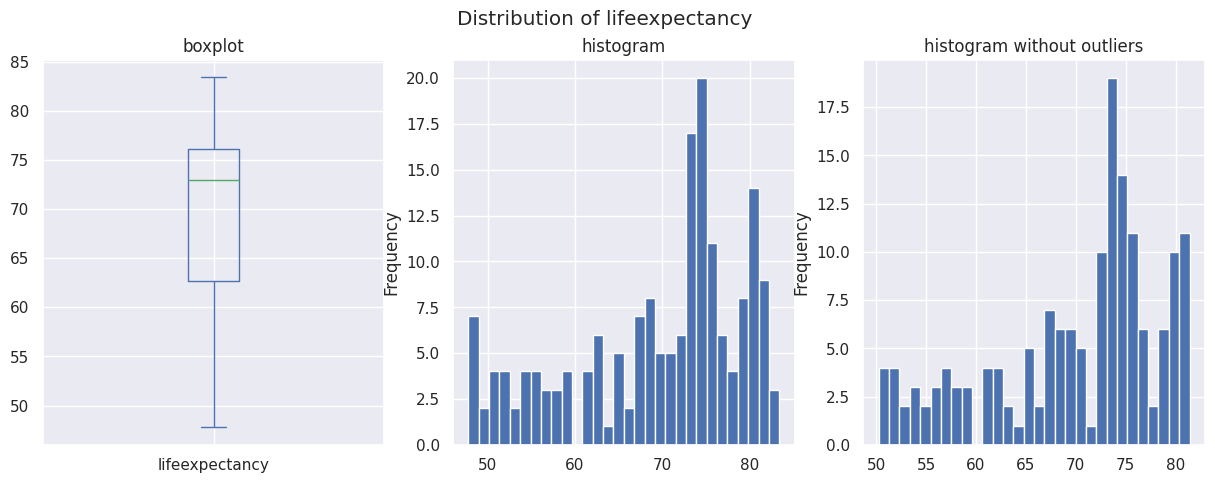

oilperperson


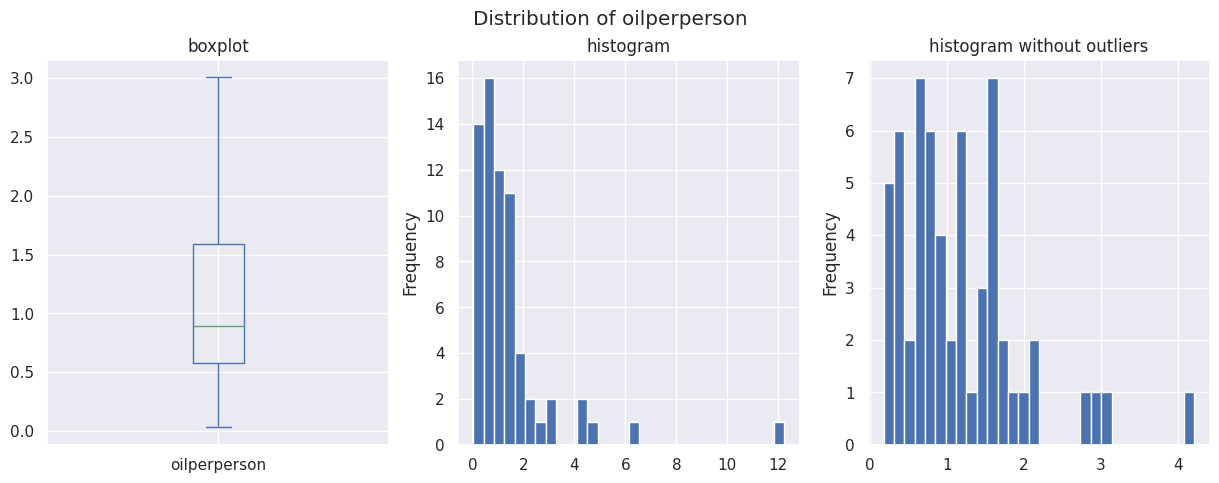

polityscore


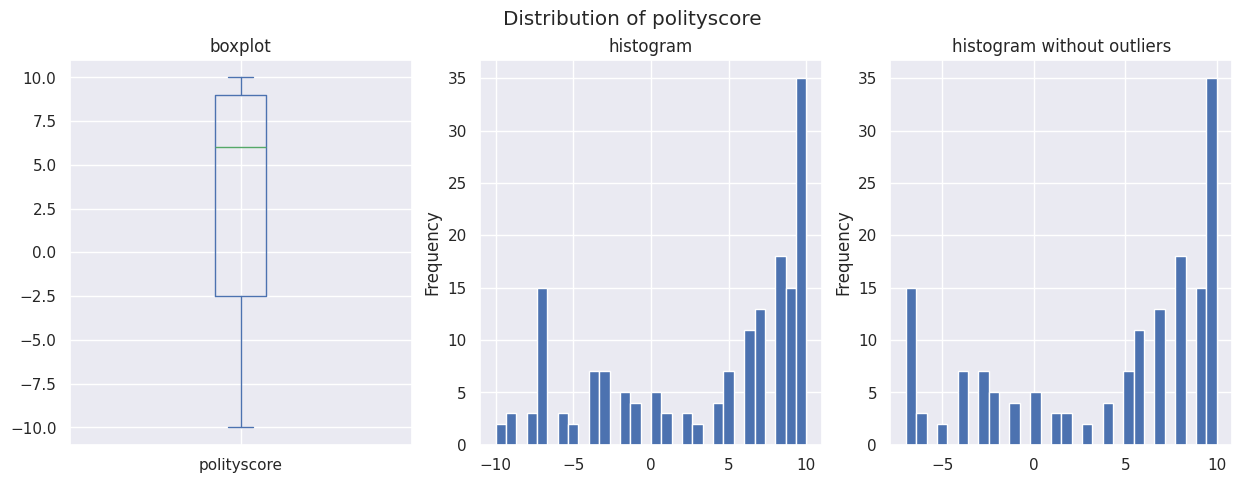

relectricperperson


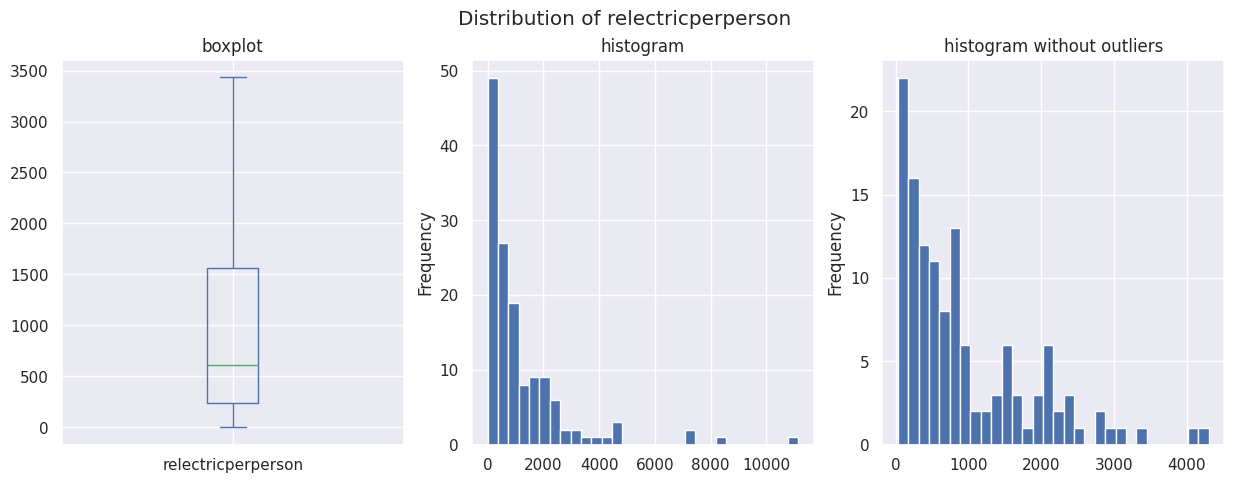

suicideper100th


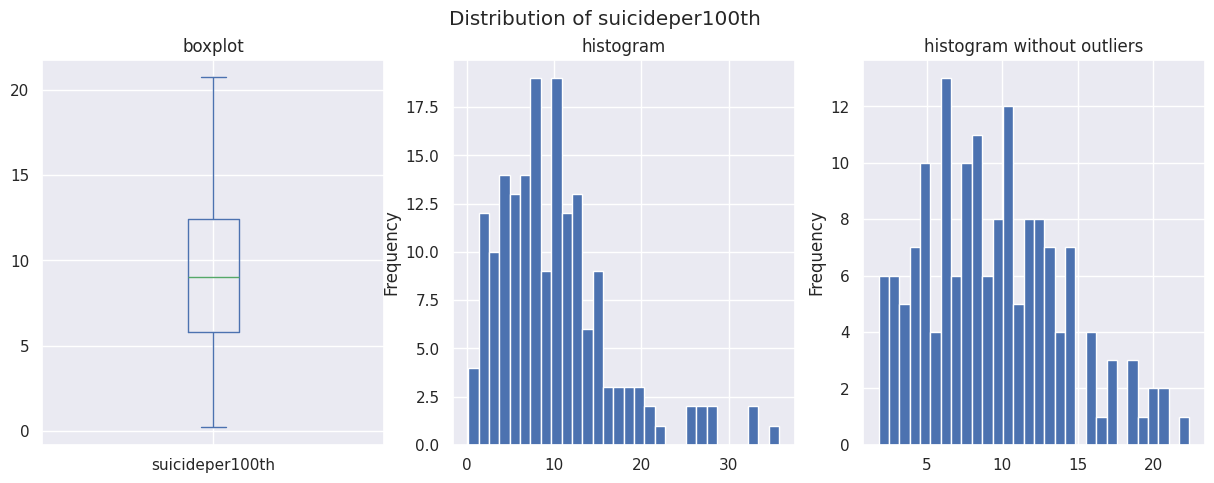

employrate


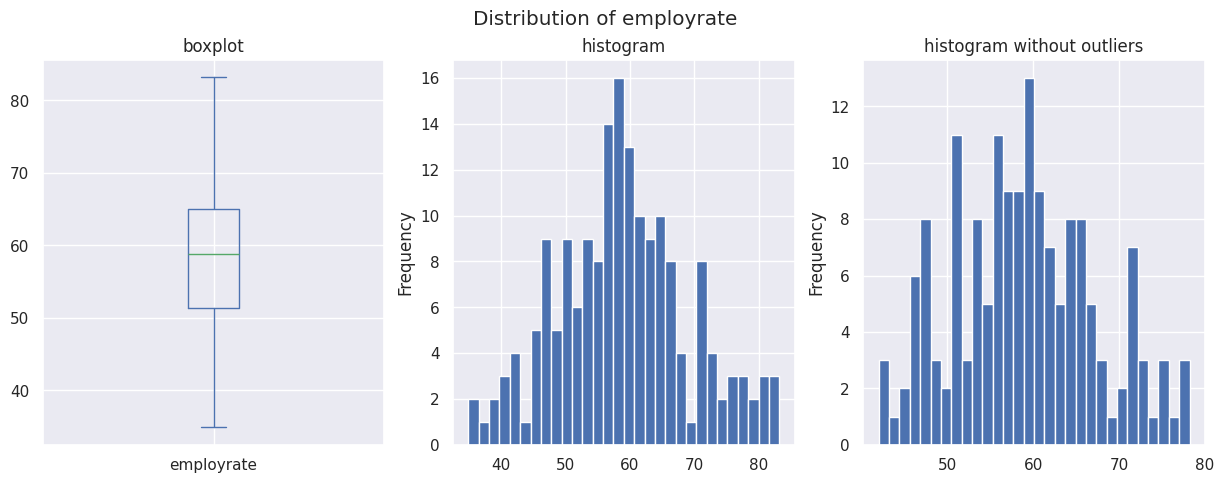

urbanrate


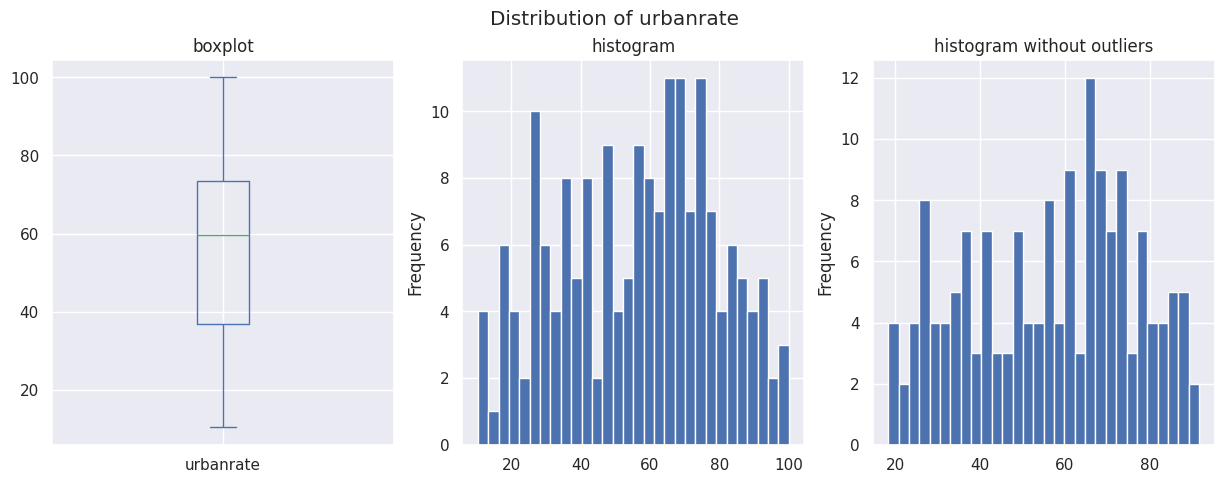

In [18]:
for col in NUMERICAL_COLUMNS:
  print(col)
  univariate_utils.plot_column_distribution(
      df_pib,
      col,
      (15,5),
      30
  )

### Bivariate analysis

#### Correlation between numerical columns

Using the absolute value of a pearson correlation for numerical variables, the following significant correlations with the target column are found:

- incomeperperson and alcconsumption: 0.31
- **incomeperperson and breastcancerper100th: 0.74**
- incomeperperson and c02emissions: 0.28
- incomeperperson and hivrate: 0.20
- **incomeperperson and internetuserate: 0.80**
- **incomeperperson and lifeexpectancy: 0.60**
- **incomeperperson and oilperperson: 0.53**
- incomeperperson and polityscore: 0.30
- **incomeperperson and relectricperperson: 0.64**
- **incomeperperson and urbanrate: 0.57**

Between indicators there are also some significant correlations than mean that a variable can be removed, for example:
- **femaleemployrate and employrate: 0.86 (females are a portion of the employment workforce)**
- **breastcancerper100th and internetuserate: 0.79 (more people in cancer is in more technologically developed countries?)**
- **hivrate and life_expectancy: -0.57 (more hiv means less life expectancy)**
- **armedforcesrate and femaleemployrate: -0.36 (more army means less women working?)**

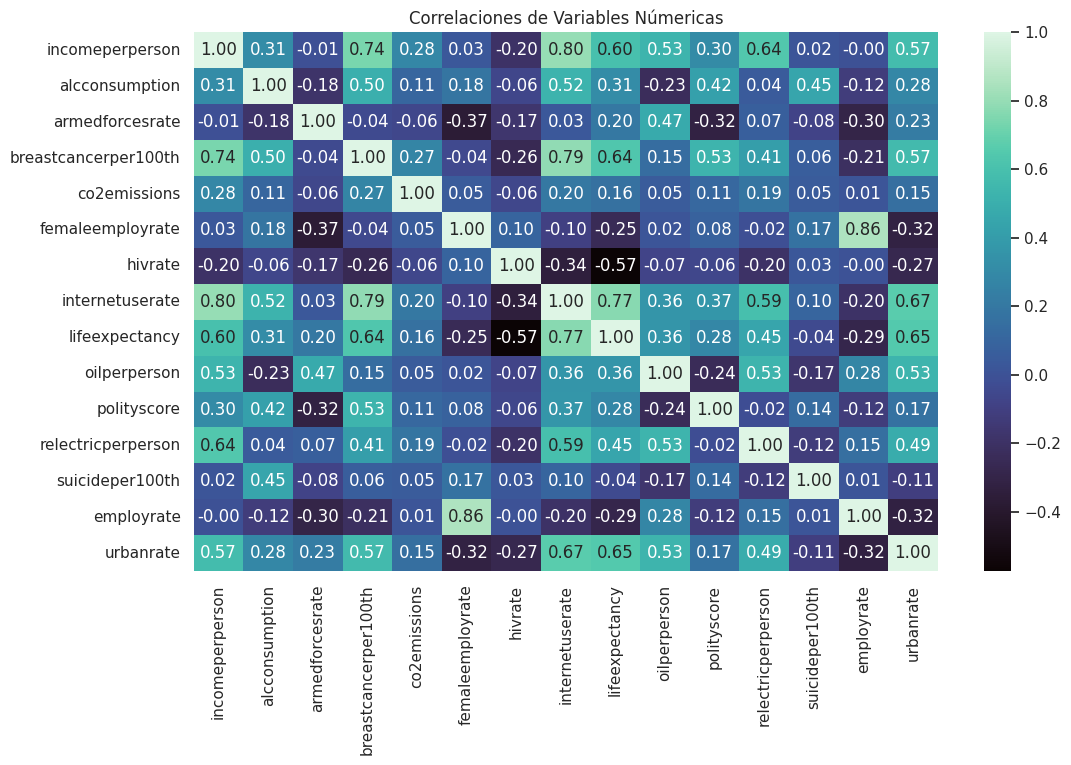

In [19]:
df_numeric = df_pib.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 7))
sns.heatmap(df_numeric.corr(), annot=True, fmt='.2f', cmap="mako")
plt.title('Correlaciones de Variables Númericas')
plt.show()
plt.close()

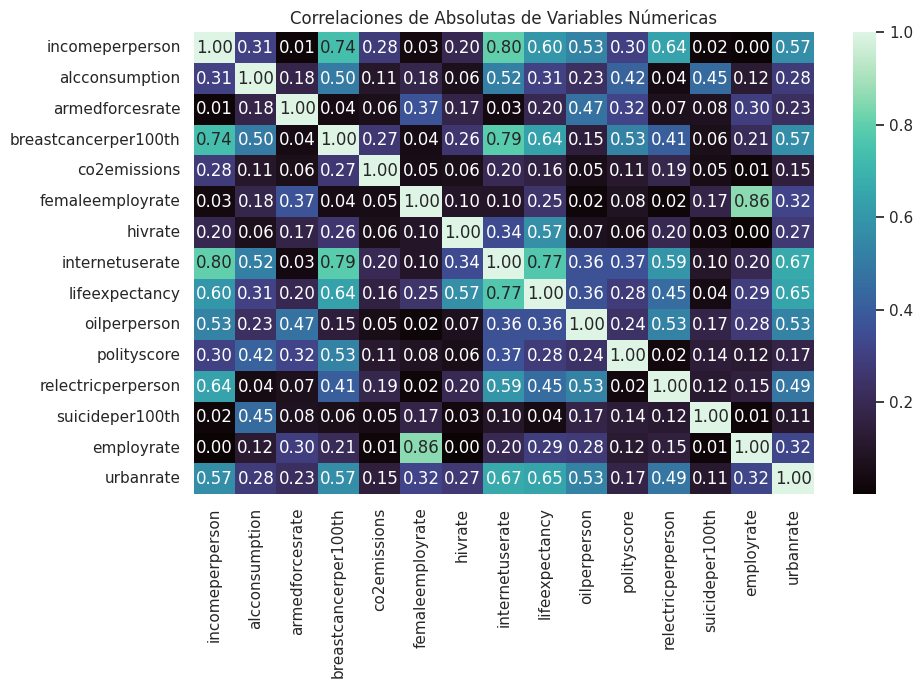

In [20]:
df_numeric = df_pib.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr().abs(), annot=True, fmt='.2f', cmap="mako")
plt.title('Correlaciones de Absolutas de Variables Númericas')
plt.show()
plt.close()

In [21]:
relevant_corrs = []
for col1, col2 in combinations(NUMERICAL_COLUMNS + ["incomeperperson"], 2):
  df_corr = multivariate_utils.test_correlation(
      df_pib,
      col1,
      col2,
      "pearson",
      0.05
  )
  if df_corr["statistic"].abs().tolist()[0] >= 0.20:
    relevant_corrs.append(df_corr)
df_relevant_corrs = pd.concat(relevant_corrs)

In [22]:
df_relevant_corrs.sort_values("statistic", ascending=False)

,value_col1,value_col2,test,statistic,pvalue,dependent
0,femaleemployrate,employrate,pearson,0.856209,4.494933e-52,True
0,internetuserate,incomeperperson,pearson,0.801176,9.397776e-40,True
0,breastcancerper100th,internetuserate,pearson,0.786570,1.220794e-37,True
0,internetuserate,lifeexpectancy,pearson,0.772185,1.042465e-35,True
0,breastcancerper100th,incomeperperson,pearson,0.737577,3.828003e-31,True
0,internetuserate,urbanrate,pearson,0.666444,1.055028e-23,True
0,lifeexpectancy,urbanrate,pearson,0.645789,2.193522e-22,True
0,relectricperperson,incomeperperson,pearson,0.638436,2.801071e-17,True
0,breastcancerper100th,lifeexpectancy,pearson,0.635182,2.198002e-21,True
0,lifeexpectancy,incomeperperson,pearson,0.599883,1.748760e-18,True


### Adding extra-categorical variables to GDP dataframe
Joining by Country name, the following columns are inserted:
- independent: Whether the country is independent or not.
- region: Continent in which the country is located.
- subregion: Region inside the continent in which the country is located.
- landlocked: If the country is landlocked or not.
- area: Land area in km2

In [23]:
df_pib = add_region_to_pib(
    df_pib,
    df_regions
)

In [24]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1

### Categorical variables vs output variable
Some boxplots are made comparing the central tendency of the output variable (GDP per capita) vs the categories in order to identify differences of GDP in groups.

#### country
Some countries, such as United States, have a GDP 400% higher than some others, for example Albania.

#### independent
GDP of not independent countries is centered around the minimum IQR value of the GDP of the developed countries.

#### region
Africa is the region with the lowest GDP, with its 75 percentile being lower than the percentile 50 of the other regions. On the other hand, Europe has the highest GDP with the percentile 25 being above the percentile 50 of the other regions.

#### subregion
Western Europe has a GDP a lot higher than the other subregions, having a minimum IQR GDP value greater than most subregions maximum IQR GDP value.

#### landlocked
Landlocked countries tend to have a lower GDP, being their 75 percentile the 50 percentile of the rest.

#### is_developed
Undeveloped countries have a lot less GDP than developed countries, having a maximum IQR GDP below the percentile 25 of the developed countries.

In [25]:
CATEGORICAL_COLUMNS = df_pib.select_dtypes(include="O")

country


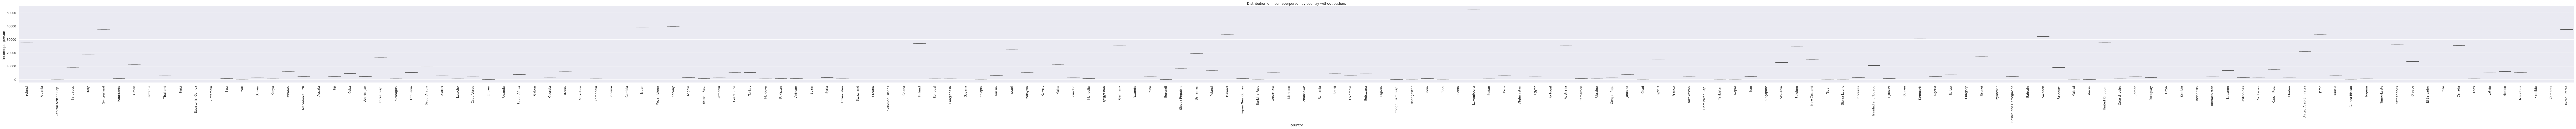

independent


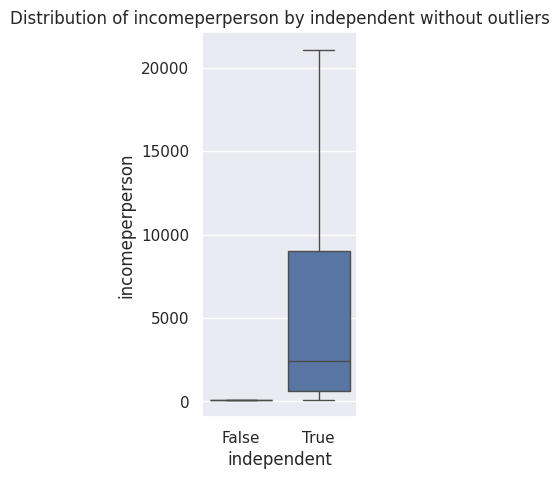

region


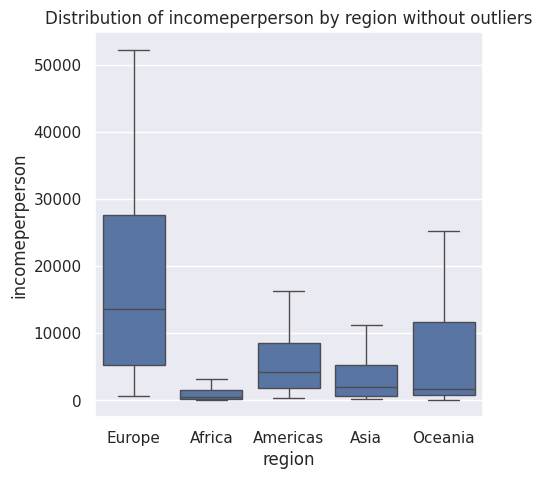

subregion


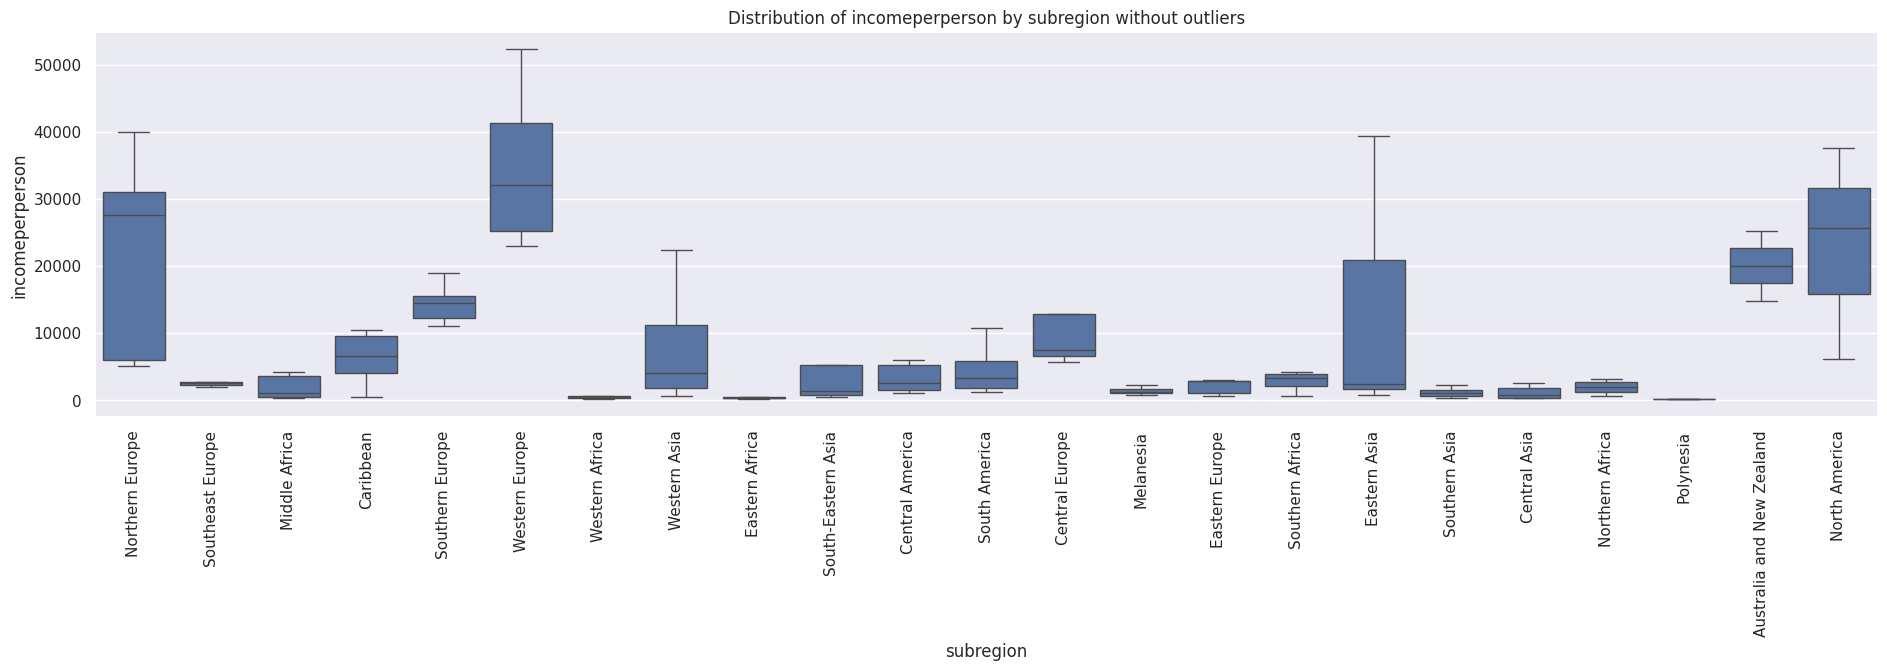

landlocked


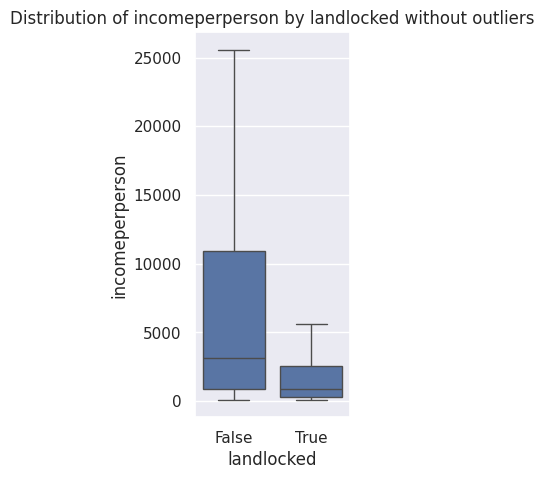

is_developed


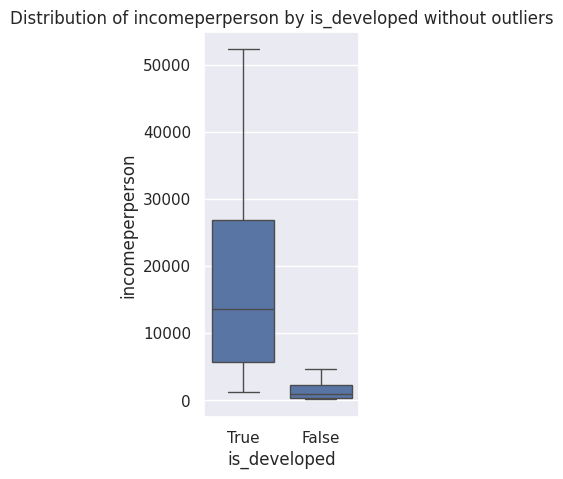

In [26]:
for col in CATEGORICAL_COLUMNS:
    print(col)
    n_cats = df_pib[col].nunique()
    multivariate_utils.plot_distributions(
        df_pib,
        TARGET_VARIABLE,
        col,
        (n_cats*1, 5),
        "box",  # Puede ser hist o box
        False 
    )

### Top indicators vs Top indicators

- breastcancerper100th is proportional to internetuserate, and this is surprising because it is expected that better technology would mean better healthcare. The same happens comparing breastcancerper100th against lifeexpectancy.
- lifeexpectancy is proportional to internetuserate, as expected.
- relectricperperson is proportional to internetuserate as expected.
- in all the top indicators, Africa seems to have the lowest values.

In [27]:
TOP_INDICATORS = [
    "breastcancerper100th",
    "internetuserate",
    "lifeexpectancy",
    "relectricperperson"
]

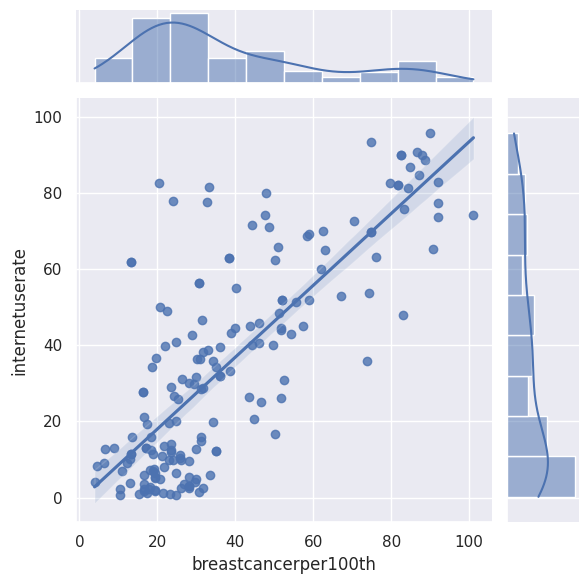

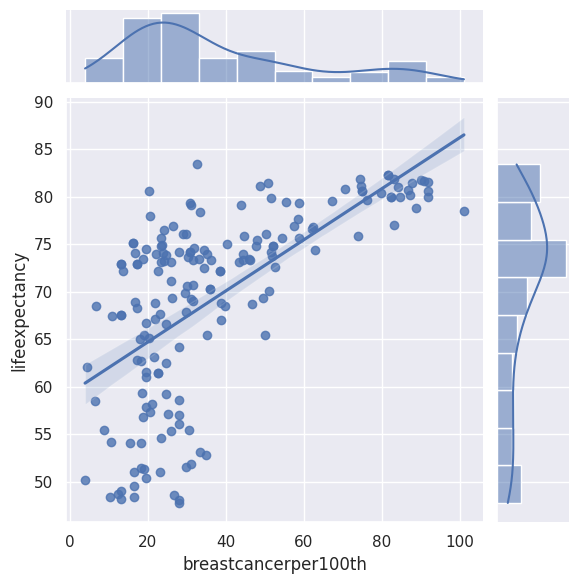

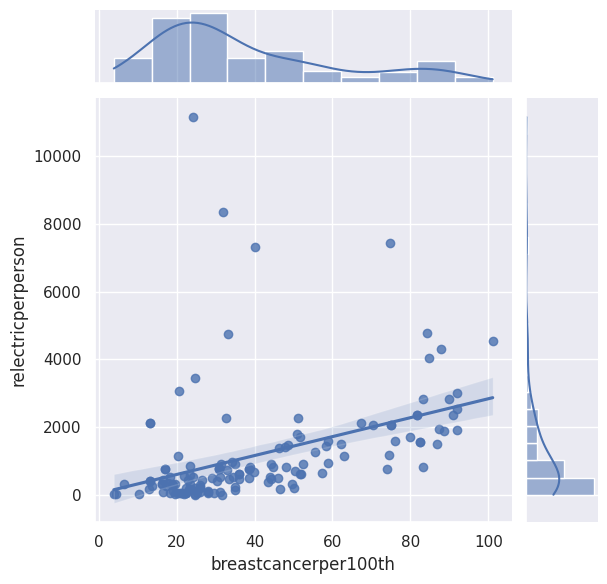

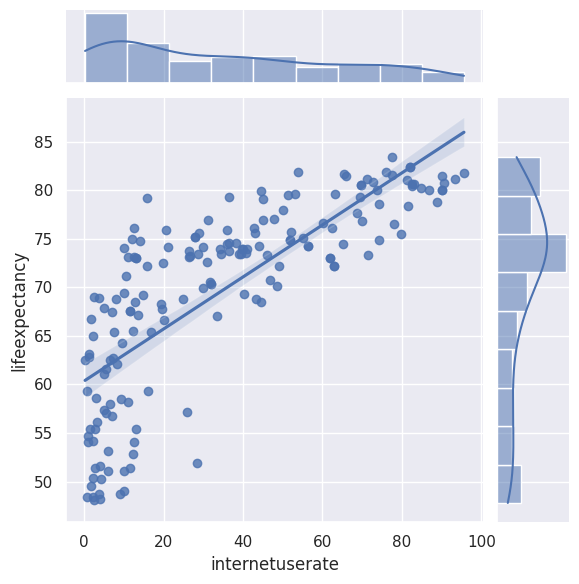

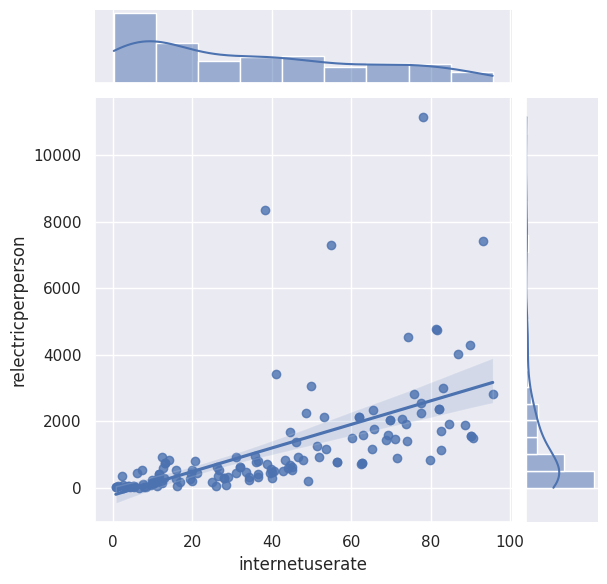

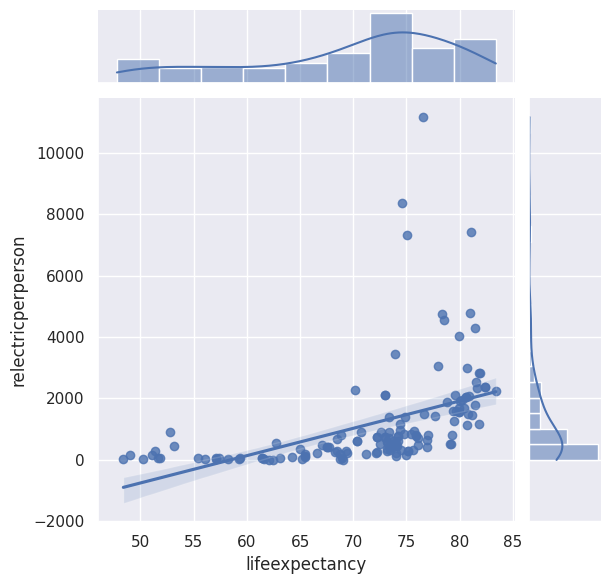

In [28]:
for top_indicator1, top_indicator2 in combinations(TOP_INDICATORS, 2):
    sns.jointplot(
        data=df_pib,
        x=top_indicator1,
        y=top_indicator2,
        kind="reg"
    )
    plt.show()
    plt.close()

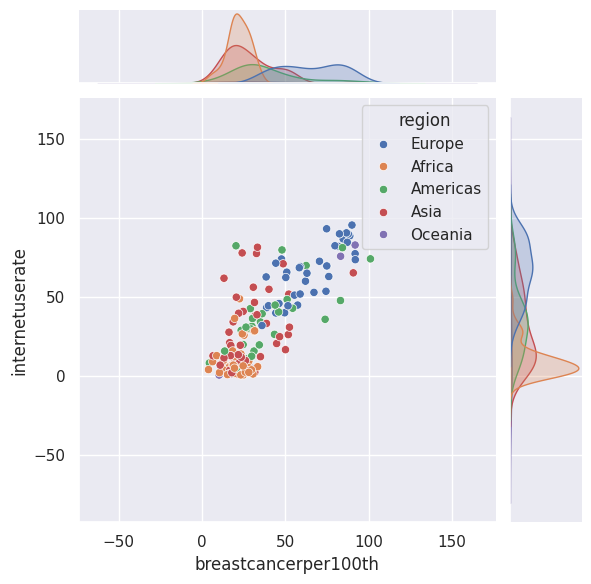

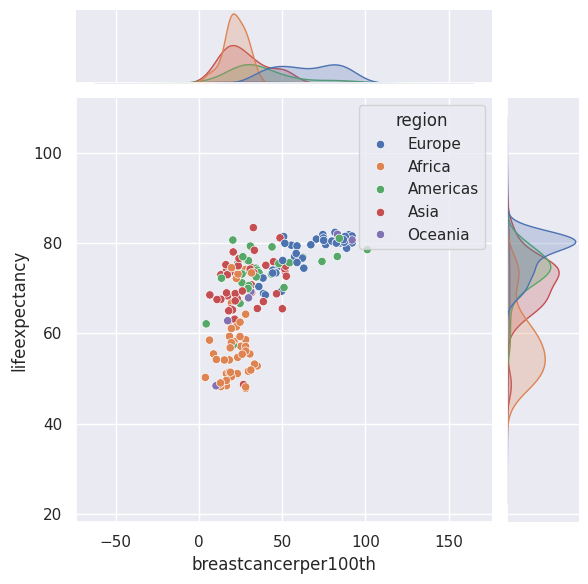

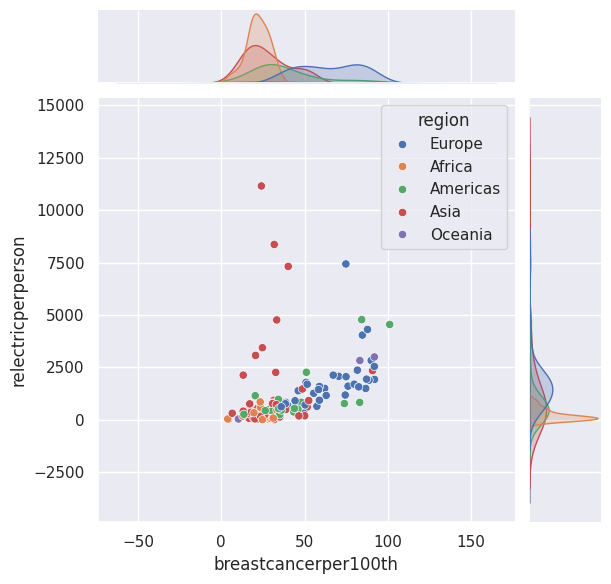

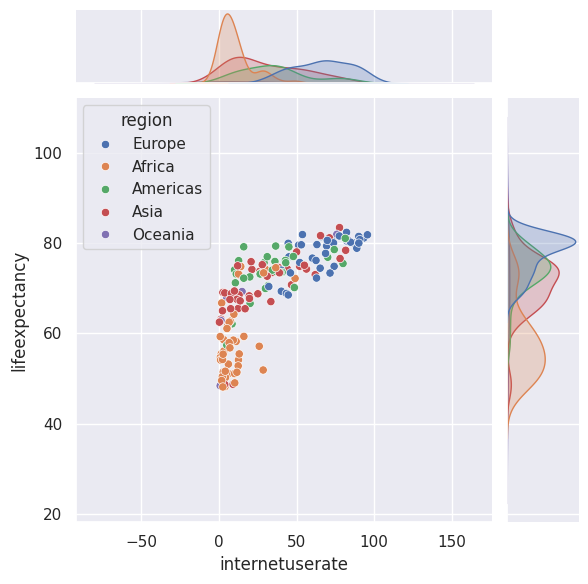

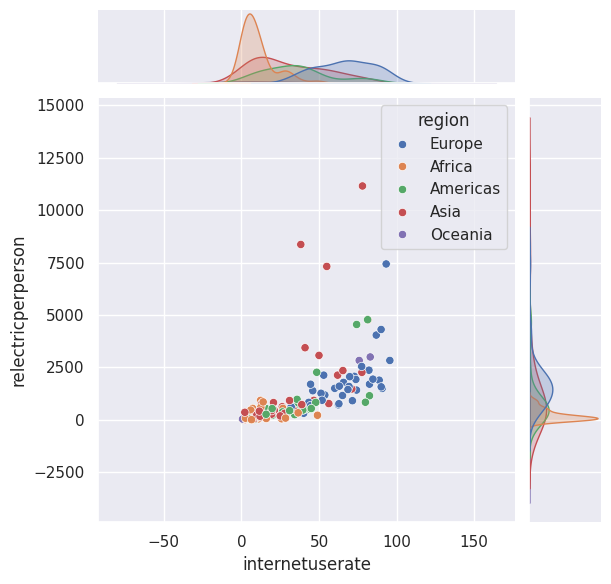

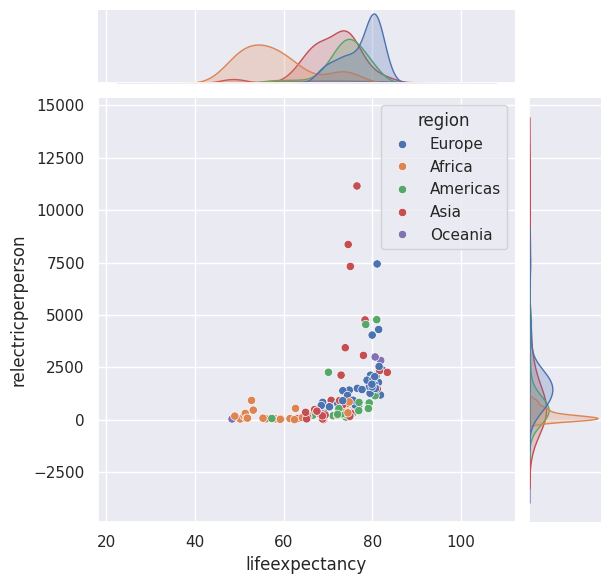

In [29]:
for top_indicator1, top_indicator2 in combinations(TOP_INDICATORS, 2):
    sns.jointplot(
        data=df_pib,
        x=top_indicator1,
        y=top_indicator2,
        hue="region",
        alpha=1.0
    )
    plt.show()
    plt.close()

### Saving dataset with new features

In [30]:
df_pib.to_parquet(SAVING_FILE_PATH, index=False)

In [31]:
df_pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country               178 non-null    object 
 1   incomeperperson       175 non-null    float64
 2   alcconsumption        178 non-null    float64
 3   armedforcesrate       174 non-null    float64
 4   breastcancerper100th  177 non-null    float64
 5   co2emissions          176 non-null    float64
 6   femaleemployrate      177 non-null    float64
 7   hivrate               155 non-null    float64
 8   internetuserate       174 non-null    float64
 9   lifeexpectancy        178 non-null    float64
 10  oilperperson          67 non-null     float64
 11  polityscore           167 non-null    float64
 12  relectricperperson    141 non-null    float64
 13  suicideper100th       178 non-null    float64
 14  employrate            177 non-null    float64
 15  urbanrate             1